In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import trange
import seaborn.apionly as sns
import statsmodels.api as sm
import cdpm
from cdpm import CondDirichletProcessMix

/home/sangrey/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
alpha_for_ci = .95
num_draws = int(3000)

In [4]:
def simulate_regime_switching(mu, sigma, rho, prop_mean, prop_coeff, time_dim=100, start_date='1995'):
    
    gamma_draws = []
    alpha_draws = []
    alpha_draws.append(stats.norm.rvs(loc=mu[1], scale=sigma)) # start with normal times
    gamma_draws.append(1)
    
    for t in range(1,time_dim):
        
        closest_regime_mean = np.argmin(alpha_draws[t-1] - mu[gamma_draws[t-1]])
                
        prop = stats.norm.cdf(prop_mean[gamma_draws[t-1]] + prop_coeff
                              *abs(alpha_draws[t-1] - mu[gamma_draws[t-1]])**2 * closest_regime_mean)
        
        if prop < stats.uniform.rvs(0,1):
            gamma_draws.append(abs(1-gamma_draws[t-1]))
        else:
            gamma_draws.append(gamma_draws[t-1])
                       
        alpha_draws.append(mu[gamma_draws[t]] + rho*alpha_draws[t-1] + sigma*stats.norm.rvs(size=1))
        
    return_data = pd.DataFrame(np.column_stack([np.asanyarray(alpha_draws), np.asanyarray(gamma_draws)]), 
                        columns=['alpha', 'regime'], index=pd.date_range(start=start_date, freq='W', 
                                                                         periods=time_dim))
    
    return return_data
    

In [5]:
simulated_data = simulate_regime_switching(mu=[-.1, .2], sigma=.5, rho=.95, prop_mean=[2.2,2.7], 
                                           prop_coeff=.5, time_dim=1000) 

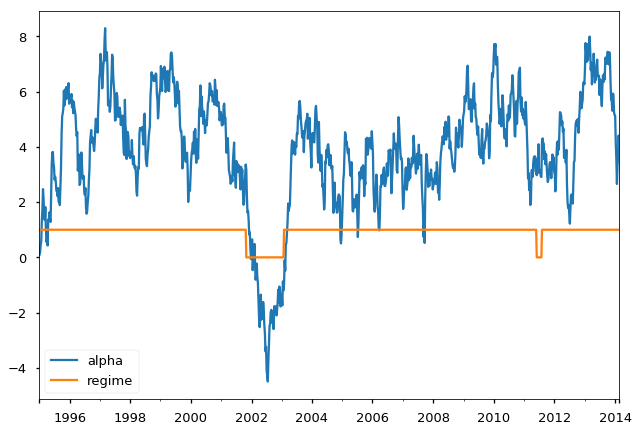

In [6]:
simulated_data.plot()

In [7]:
simulated_data.describe()

alpha       regime
count  1000.000000  1000.000000
mean      3.856831     0.926000
std       2.103277     0.261902
min      -4.496331     0.000000
25%       2.870198     1.000000
50%       3.951995     1.000000
75%       5.276462     1.000000
max       8.298280     1.000000

In [8]:
alpha_series = simulated_data.alpha.values

## Estimation

In [9]:
stick_scale = 2
beta_mu, beta_sigma = .9, 0.1 # mean and standard deviation
comp_cov_df, comp_cov_scale = 3, .5

In [10]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'cov': {'scale': [comp_cov_scale], 'df': [comp_cov_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [11]:
print("The mean component covariance is {0:.3f}".format(comp_cov_scale / (comp_cov_df - 1)))

The mean component covariance is 0.250


In [12]:
time_dim = simulated_data.shape[0]
regressor_dim = 1
regressand_dim = 1
max_num_clusters = 60

## Initialization

In [13]:
model = CondDirichletProcessMix(beta_mu, comp_cov=.5,regressor=alpha_series[:-1], 
                                regressand=alpha_series[1:])

In [14]:
cluster_identity_draws = np.empty((num_draws, time_dim-1))
stick_draws = np.full((num_draws, max_num_clusters),np.nan)
beta_draws = np.full((num_draws, max_num_clusters, regressor_dim, regressand_dim),np.nan)
comp_cov_draws = np.full((num_draws, max_num_clusters, regressand_dim, regressand_dim),np.nan)
trans_mat_draws = np.full((num_draws, max_num_clusters, max_num_clusters),np.nan)

In [15]:
for draw_idx in trange(num_draws):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2]), :, :] = model_posterior[2]
    comp_cov_draws[draw_idx, :len(model_posterior[3]), :, :] = model_posterior[3]
    trans_mat_draws[draw_idx,:model_posterior[4].shape[0], :model_posterior[4].shape[1]] = model_posterior[4]

100%|██████████| 3000/3000 [00:04<00:00, 606.07it/s]


In [16]:
pd.DataFrame(np.squeeze(np.nanmean(comp_cov_draws, axis=0))).dropna().mean()

/home/sangrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


0    0.921915
dtype: float64

## Simulation results

In [17]:
percentiles = [.1, 1,5, 25, 50, 75, 95, 99, 99.9]

In [18]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

## Get the dynamics of alpha

In [19]:
beta_est = np.array(pd.DataFrame(beta_draws).mean().dropna())

ValueError: Must pass 2-d input

In [20]:
alpha_est_mat = np.empty((time_dim-1, num_draws//5))

In [21]:
for draw in trange(alpha_est_mat.shape[1]):
    for t_idx in range(1, time_dim):
        cluster_identity = cluster_identity_draws[draw,t_idx-1].astype(int)
        cl_idx = np.argmax(np.random.multinomial(n=1,pvals=trans_mat_draws[draw][cluster_identity,:]).astype(np.bool))
        alpha_f = (alpha_series[t_idx-1] * beta_draws[draw, cl_idx] 
                   + comp_cov_draws[draw, cl_idx]**(.5) * np.random.normal(0,1, size=1))
        alpha_est_mat[t_idx-1, draw] = np.asscalar(alpha_f)

100%|██████████| 600/600 [00:11<00:00, 51.10it/s]


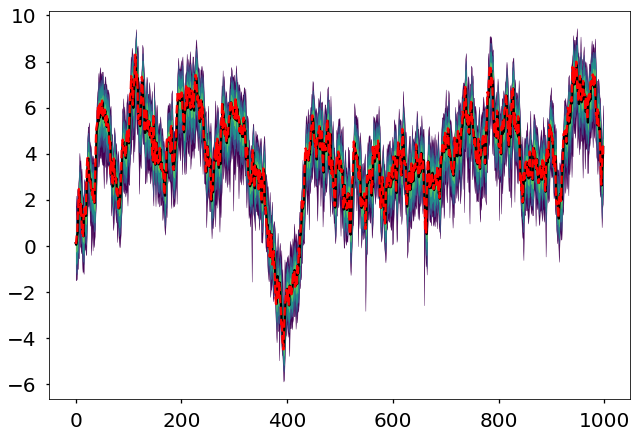

In [26]:
alpha_comparison_fig, alpha_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(alpha_comparison_ax, pd.DataFrame(alpha_est_mat), percentiles, color='black')
alpha_comparison_ax.plot(alpha_series[1:], c='red', linestyle='--')
for label in alpha_comparison_ax.get_xticklabels():
    label.set_fontsize(20)
for label in alpha_comparison_ax.get_yticklabels():
    label.set_fontsize(20)
alpha_comparison_filename = '../doc/figures/alpha_series_est1.tmp.png'
alpha_comparison_fig.savefig(alpha_comparison_filename, bbox_inches='tight', pad_inches=0)

In [23]:
pit1 = mcmc.probability_integral_transform(alpha_est_mat, alpha_series[1:])

/home/sangrey/anaconda3/lib/python3.6/site-packages/bayesiankalman/mcmc.py:643: RuntimeWarning: invalid value encountered in less_equal
  return_vals = np.asarray([np.mean(np.less_equal(data, point), axis=0) for point in eval_points])


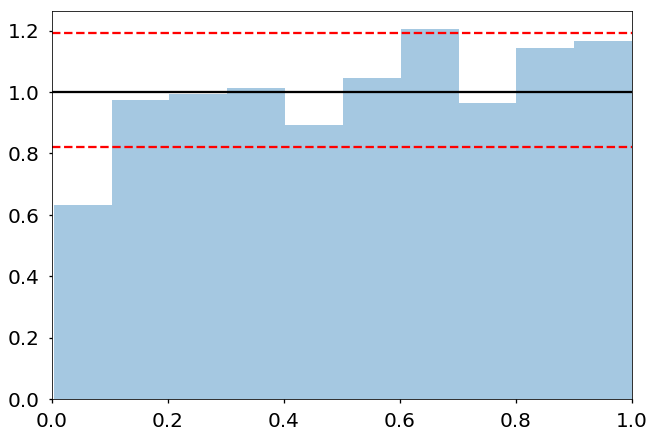

In [27]:
pit_fig = plt.figure()
pit_ax = pit_fig.add_subplot(111)
nbins = 10
sns.distplot(pit1, kde=False, norm_hist=True, ax=pit_ax, bins=nbins)
pit_ax.set_xlim([0,1])
for label in pit_ax.get_xticklabels():
    label.set_fontsize(20)
for label in pit_ax.get_yticklabels():
    label.set_fontsize(20)
pit_ci_top, pit_ci_bottom = stats.binom.interval(alpha=alpha_for_ci, n=pit1.size, p=nbins**(-1)) 
pit_ax.axhline(pit_ci_bottom * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(pit_ci_top * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(1, color='black')
pit_fig.savefig('../doc/figures/pit_est1.png', bbox_inches='tight', pad_inches=0)

In [40]:
?sm.tsa.acf

50

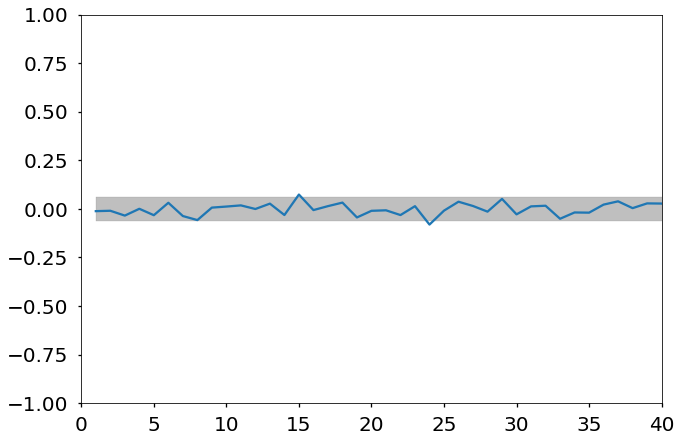

In [48]:
acf_fig, acf_ax = plt.subplots()
nlags = 50
acf_ax.plot(np.arange(1, nlags),sm.tsa.acf(x=pit1, unbiased=True, nlags=nlags-1)[1:])
acf_ax.fill_between(np.arange(1,nlags), -1.96 * pit1.size**(-.5), 1.96 * pit1.size**(-.5), color='grey', 
                    alpha=.5)
acf_ax.set_ylim([-1,1])
for label in acf_ax.get_xticklabels():
    label.set_fontsize(20)
for label in acf_ax.get_yticklabels():
    label.set_fontsize(20)
acf_ax.set_xlim([0, 40])
acf_fig.savefig('../doc/figures/acf_est1.tmp.png', bbox_inches='tight', pad_inches=0)